## Final Project Submission

Please fill out:
* Student name: Lyndsay Maggin
* Student pace: self paced / part time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn import linear_model
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Understand the Data

In [2]:
df = pd.read_csv("kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.shape

(21597, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


#### Column Definitions

##### This dataset was created in 2016, therefore assume data is being used for 2016 housing sales

* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront (0,1,nan)
* **view** - Has been viewed (0-4, nan)
* **condition** - How good the condition is ( Overall ) (1-5)
* **grade** - overall grade given to the housing unit, based on King County grading system (3-13)
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

In [5]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [6]:
list(set(df['yr_renovated'].dropna()))[-5:]

[2011.0, 2012.0, 2013.0, 2014.0, 2015.0]

In [7]:
columns =list(df.columns)

In [8]:
for col in columns:
    print(col,':', df[col].nunique())

id : 21420
date : 372
price : 3622
bedrooms : 12
bathrooms : 29
sqft_living : 1034
sqft_lot : 9776
floors : 6
waterfront : 2
view : 5
condition : 5
grade : 11
sqft_above : 942
sqft_basement : 304
yr_built : 116
yr_renovated : 70
zipcode : 70
lat : 5033
long : 751
sqft_living15 : 777
sqft_lot15 : 8682


In [9]:
df['sqft_basement'] = df['sqft_basement'].replace('?', '0.0')

In [10]:
df['sqft_basement'] = df['sqft_basement'].astype('float64')

# Synopsis

### The King County dataset is a list of homes sold between May 2014 and May 2015 in King County, Washington State (inclusive of Seattle). It is 2016 and I am a realtor in the King County Washington area working with a new family to find their forever home. Using this dataset, with my newly learned data science tools, I can predict the price that a home of interest will sell at and therefore can assist the family in entering a proper bid. 

#### Data Cleaning

In [11]:
#Out of 21597 homes, 63 do not have view information, 2376 do not have waterfront information and 3842 do not have renovation information.
#This makes up 0%, 11% and 18% of total homes respectively. For data munging purposes I will therefore assume these properties
#are not waterfront and have not been renovated. 

df = df.fillna(0)

In [12]:
categorical = ['floors', 'view', 'condition', 'grade', 'waterfront']

In [13]:
continuous = columns
for cat in categorical:
    countinuous = continuous.remove(cat)

In [14]:
continuous.remove('id')

In [15]:
continuous.remove('price')

In [16]:
continuous.remove('date')

In [17]:
continuous

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

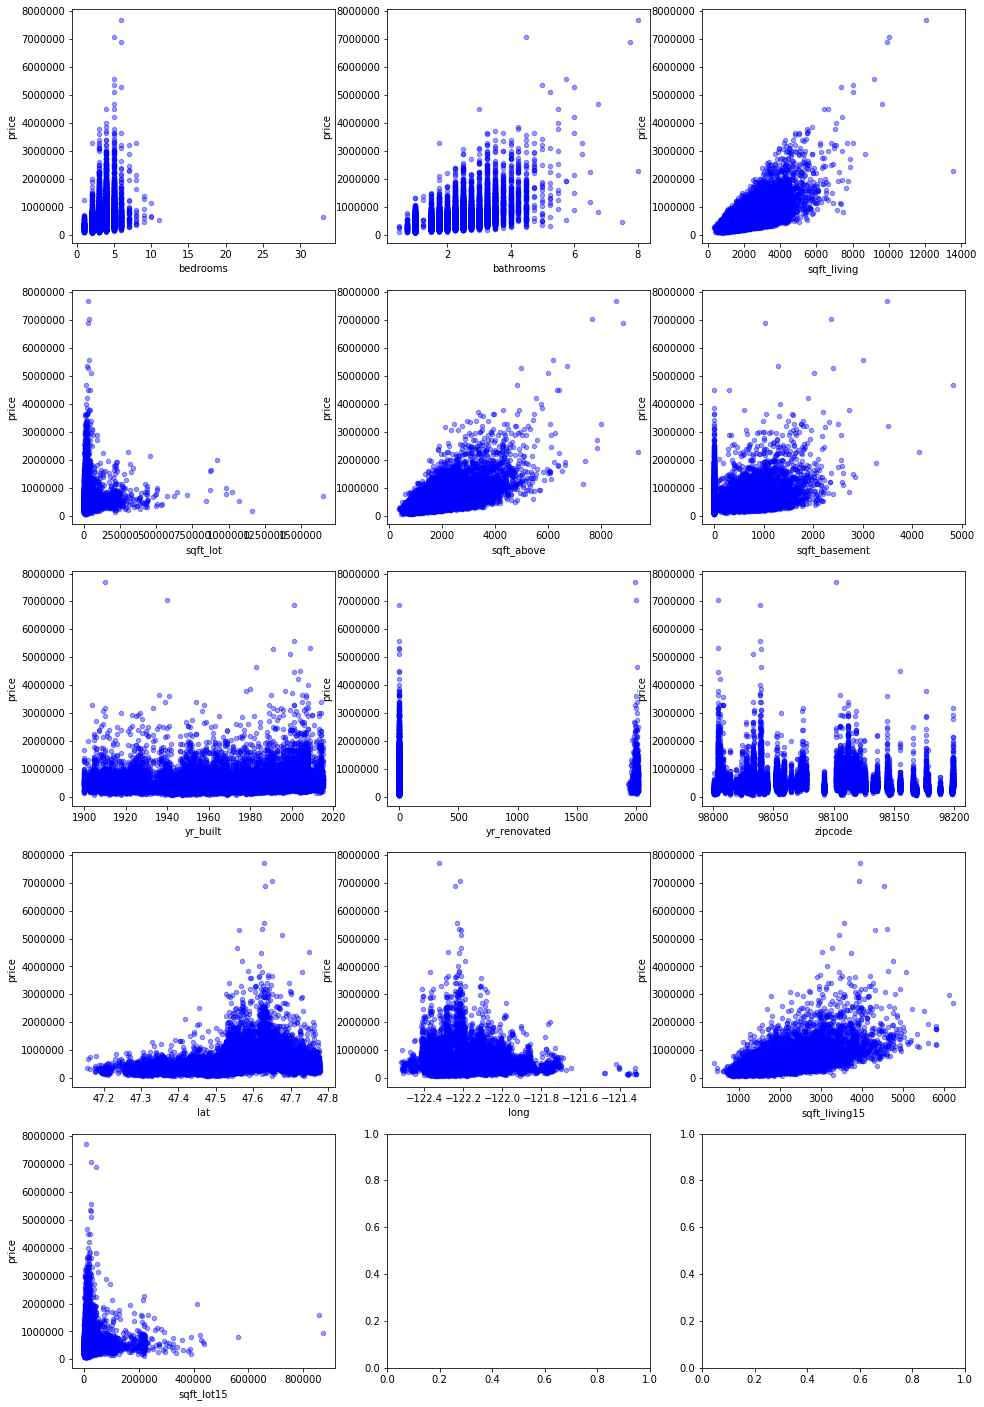

In [18]:
fig,axes = plt.subplots(5,3, figsize=(16,25))


for xcol, ax in zip(continuous, [x for v in axes for x in v]):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

In [19]:
#lat and log variables are more curved rather than linear
#the sqft variable seem to have a linear relationship with price
#it is hard to tell about rennovation date with all of non reno figures, I will therefore remove these

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002192F473710>,
      dtype=object)

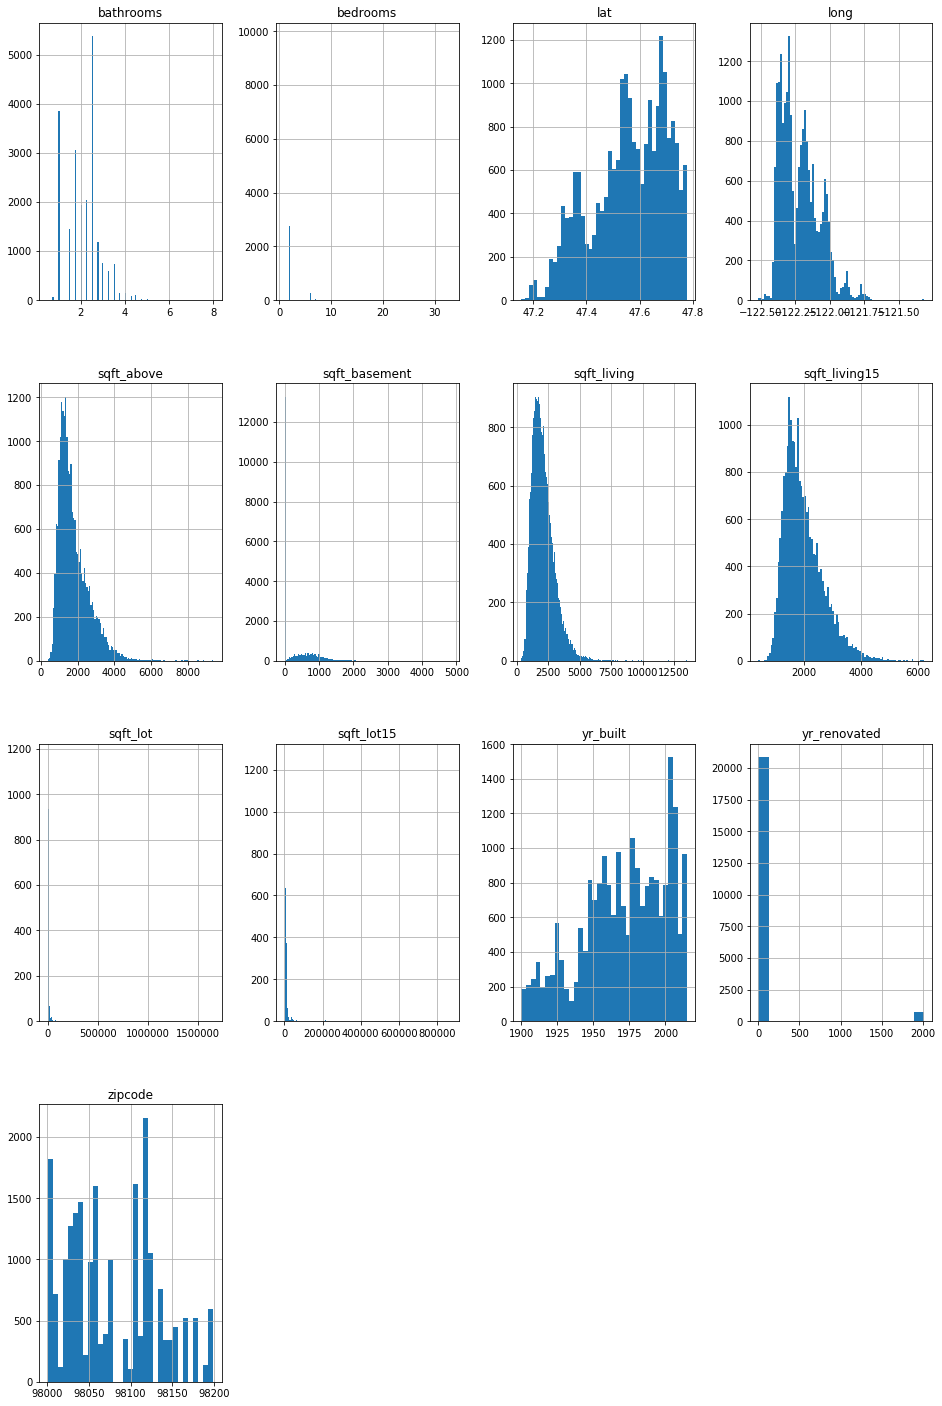

In [20]:
cont = df[continuous]
cont.hist(figsize = [16,25], bins='auto')

In [21]:
df_reno = df[['price', 'yr_renovated']]
df_reno = df_reno[df_reno.yr_renovated != 0]

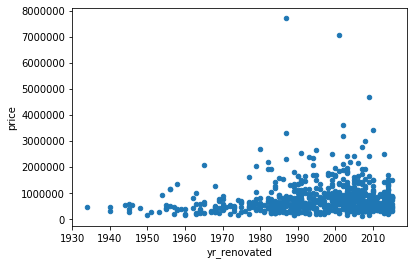

In [22]:
df_reno.plot(kind='scatter', x='yr_renovated', y='price')

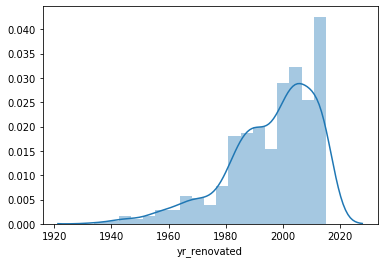

In [23]:
sns.distplot(df_reno['yr_renovated'])

In [24]:
#the majority of renovations have happened in the last 15 years, might be better to look at the relationship
#between sales price and if the home has been renovated in the last 15 years or not

In [25]:
def fifteen_years(df):
    if df['yr_renovated'] >= 2005:
        return 1
    else: 
        return 0
        
df_reno['greater_fifteen'] = df_reno.apply(fifteen_years, axis=1)

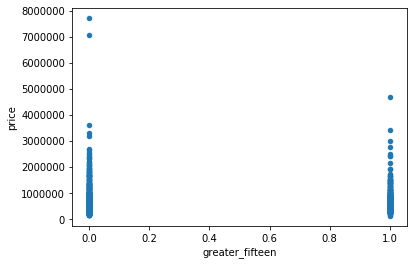

In [26]:
df_reno.plot(kind='scatter', x='greater_fifteen', y='price') #doesnt look too meaningful

In [27]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.003599,0.011772,-0.023803,0.008188,-0.010799,-0.004359,0.021617,-0.010612,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.264306,0.393497,0.036056,0.667951,0.605368,0.321108,0.053953,0.117855,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002127,0.078354,0.026496,0.356563,0.479386,0.297229,0.155670,0.017900,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.063629,0.186016,-0.126479,0.665838,0.686668,0.278485,0.507173,0.047177,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.104637,0.281715,-0.059445,0.762779,0.876448,0.428660,0.318152,0.051060,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.021459,0.075054,-0.008830,0.114731,0.184139,0.015031,0.052946,0.004979,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.020797,0.028414,-0.264075,0.458794,0.523989,-0.241866,0.489193,0.003793,-0.059541,0.049239,0.125943,0.280102,-0.010722
waterfront,-0.003599,0.264306,-0.002127,0.063629,0.104637,0.021459,0.020797,1.000000,0.380543,0.016648,0.082818,0.071778,0.083050,-0.024487,0.073939,0.028923,-0.012157,-0.037628,0.083823,0.030658
view,0.011772,0.393497,0.078354,0.186016,0.281715,0.075054,0.028414,0.380543,1.000000,0.045622,0.249082,0.166017,0.270629,-0.054452,0.090339,0.085059,0.006321,-0.077702,0.278928,0.073083
condition,-0.023803,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.016648,0.045622,1.000000,-0.146896,-0.158904,0.168482,-0.361592,-0.055808,0.002888,-0.015102,-0.105877,-0.093072,-0.003126


In [28]:
abs(df.corr())>.75

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [29]:
df_c = df.corr().abs().stack().reset_index().sort_values(0, ascending = False)
df_c['pairs'] = list(zip(df_c.level_0, df_c.level_1))
df_c.set_index(['pairs'], inplace = True)
df_c.drop(columns = ['level_0', 'level_1'], inplace = True)
df_c.columns =['cc']
df_c.drop_duplicates(inplace = True)

In [30]:
df_c.head(10)

,cc
pairs,
"(id, id)",1.000000
"(sqft_above, sqft_living)",0.876448
"(sqft_living, grade)",0.762779
"(sqft_living15, sqft_living)",0.756402
"(grade, sqft_above)",0.756073
"(sqft_living, bathrooms)",0.755758
"(sqft_living15, sqft_above)",0.731767
"(sqft_lot, sqft_lot15)",0.718204
"(sqft_living15, grade)",0.713867


In [31]:
#you can see here that sqft_living and sqft_above are hightly correlated and therefore both variables are not needed
#as well as grade
#removing grade, sqft_above, sqft_living15

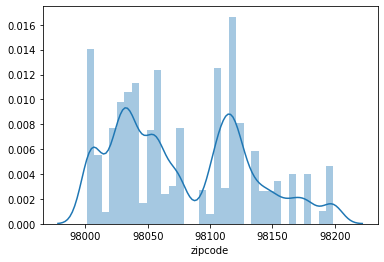

In [32]:
sns.distplot(df['zipcode'])

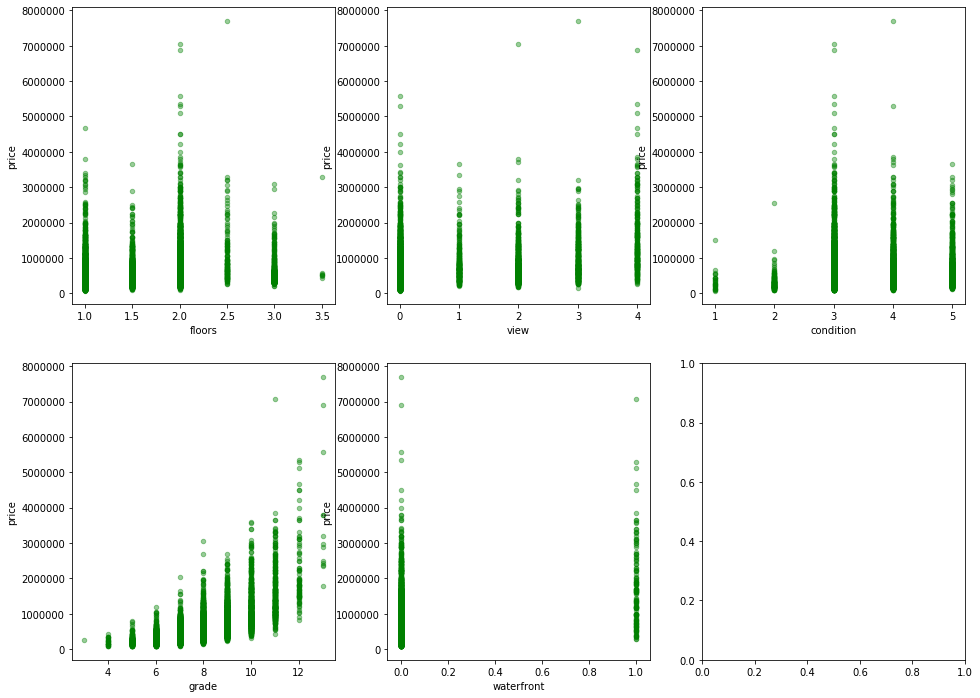

In [33]:
fig,axes = plt.subplots(2,3, figsize=(16,12))


for xcol, ax in zip(categorical, [x for v in axes for x in v]):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='g')

In [34]:
#looking at the above, view and waterfront do not seem to have any relationship with price.
#I therefore plan to remove these variables

#### Standardizing

In [35]:
#based on the charts above, I have chosen the below variables
cont_var = ['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'yr_renovated',
 'zipcode',
 'lat',
 'long']

##### Logging each continuous variable with the exception of geographic variables

In [36]:
df_logged = pd.DataFrame([])

df_logged['lg_bedrooms'] = np.log(df['bedrooms'])#
df_logged['lg_bathrooms'] = np.log(df['bathrooms'])#
df_logged['lg_sqft_living'] = np.log(df['sqft_living'])
df_logged['lg_sqft_lot'] = np.log(df['sqft_lot'])#
#df_logged['lg_yr_reno'] = np.log(df['yr_renovated'])#
#df_logged['lg_zip'] = np.log(df['zipcode'])#
#df_logged['lg_lat'] = np.log(df['lat'])#
#df_logged['lg_long'] = np.log(df['long'])#

In [37]:
#logged_continuous_variables = ['lg_sqft_living','lg_sqft_above','lg_sqft_living15' ]
logged_continuous_variables = ['lg_bedrooms', 'lg_bathrooms','lg_sqft_living','lg_sqft_lot']

In [38]:
df_logged['price'] = df['price']

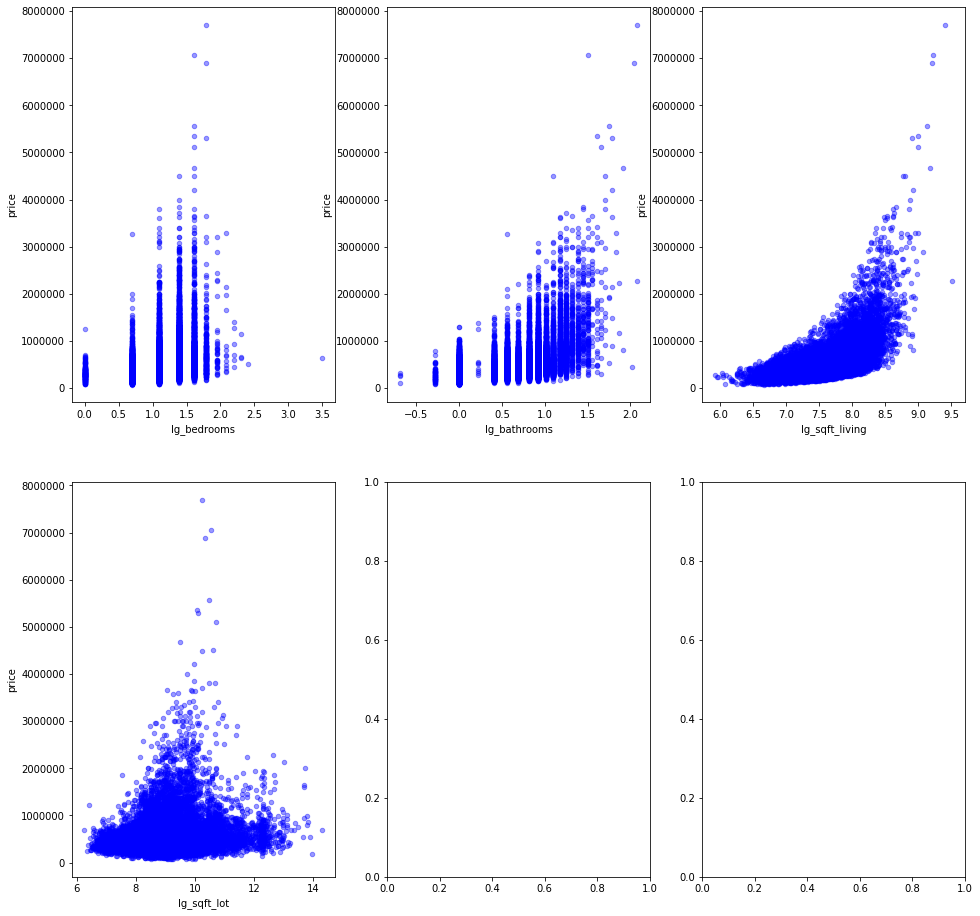

In [39]:
fig,axes = plt.subplots(2,3, figsize=(16,16))


for xcol, ax in zip(logged_continuous_variables, [x for v in axes for x in v]):
    df_logged.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002192F41D3C8>,
      dtype=object)

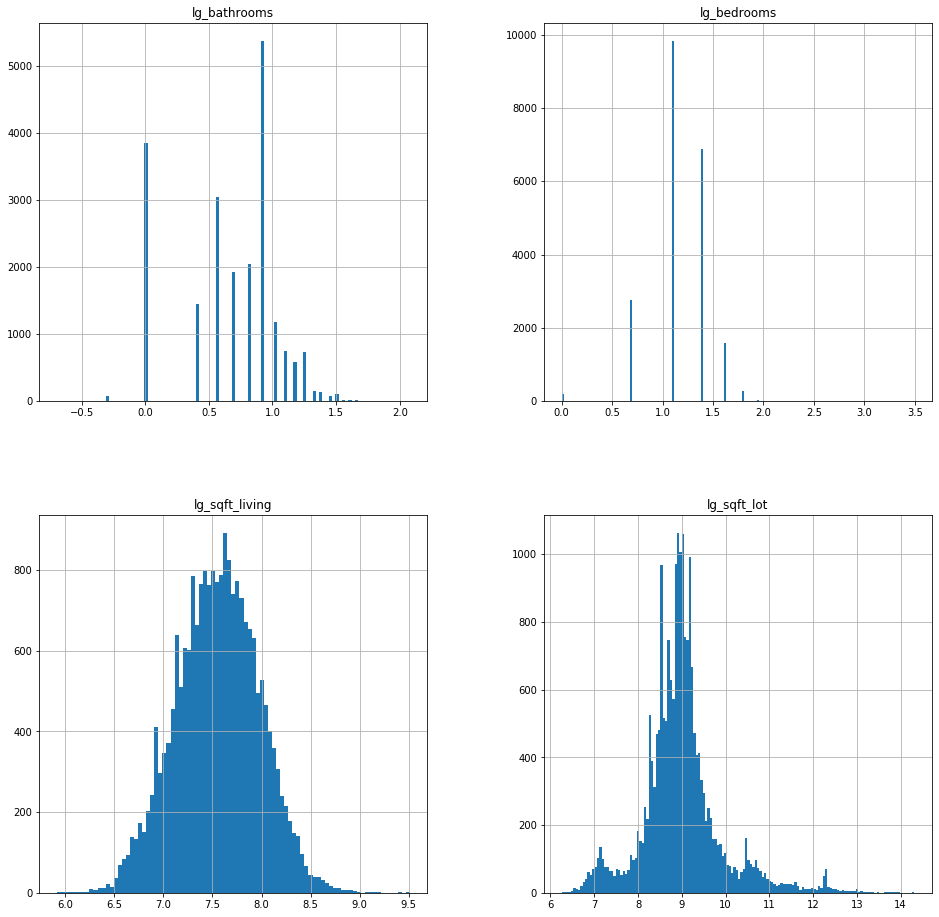

In [40]:
log_hist = df_logged[logged_continuous_variables]
log_hist.hist(figsize = [16,16], bins='auto')

##### Scaling the logged continuous variables

In [41]:
df_scaled = pd.DataFrame([])

df_scaled['scaled_bedrooms'] = (df_logged['lg_bedrooms'] - np.mean(df_logged['lg_bedrooms']))/np.sqrt(np.var(df_logged['lg_bedrooms']))
df_scaled['scaled_bathrooms'] = (df_logged['lg_bathrooms'] - np.mean(df_logged['lg_bathrooms']))/np.sqrt(np.var(df_logged['lg_bathrooms']))
df_scaled['scaled_sqft_living'] = (df_logged['lg_sqft_living'] - np.mean(df_logged['lg_sqft_living']))/np.sqrt(np.var(df_logged['lg_sqft_living']))
df_scaled['scaled_sqft_lot'] = (df_logged['lg_sqft_lot'] - np.mean(df_logged['lg_sqft_lot']))/np.sqrt(np.var(df_logged['lg_sqft_lot']))
#df_scaled['scaled_yr_reno'] = (df['yr_renovated'] - np.mean(df['yr_renovated']))/np.sqrt(np.var(df['yr_renovated']))
#df_scaled['scaled_zip'] = (df['zipcode'] - np.mean(df['zipcode']))/np.sqrt(np.var(df['zipcode']))
#df_scaled['scaled_lat'] = (df['lat'] - np.mean(df['lat']))/np.sqrt(np.var(df['lat']))
#df_scaled['scaled_long'] = (df['long'] - np.mean(df['long']))/np.sqrt(np.var(df['long']))


In [42]:
df_scaled['price'] = df['price']

In [43]:
#scaled_continuous_variables = ['scaled_sqft_living','scaled_sqft_above','scaled_sqft_living15'     ]
scaled_continuous_variables = ['scaled_bedrooms','scaled_bathrooms', 'scaled_sqft_living','scaled_sqft_lot']

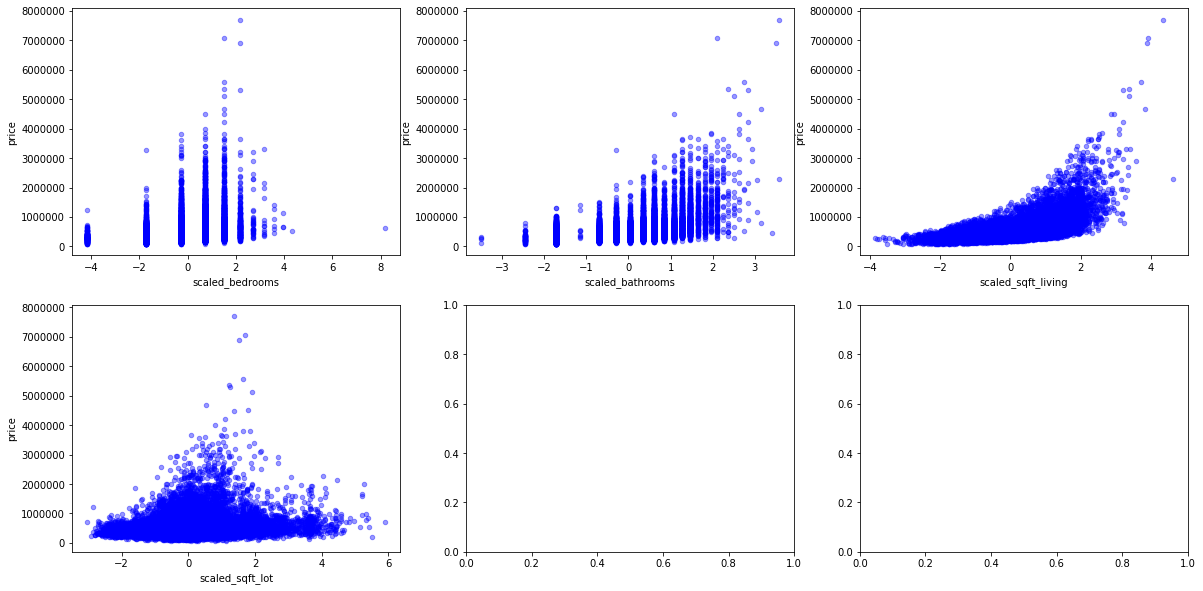

In [44]:
fig,axes = plt.subplots(2,3, figsize=(20,10))


for xcol, ax in zip(scaled_continuous_variables, [x for v in axes for x in v]):
    df_scaled.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002192EFFB7F0>,
      dtype=object)

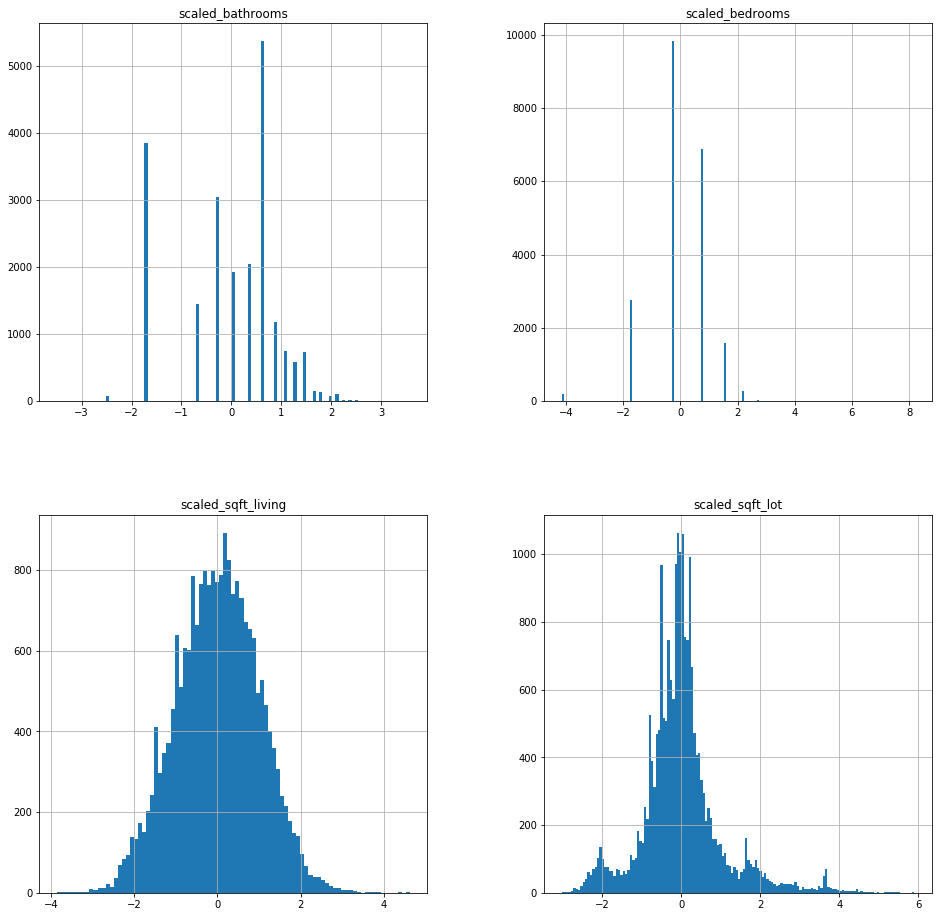

In [45]:
scaled = df_scaled[scaled_continuous_variables]
scaled.hist(figsize = [16,16], bins='auto')

In [78]:
df_std = pd.DataFrame([])

In [84]:
df_std['bedrooms'] = df_scaled['scaled_bedrooms']
df_std['bathrooms'] = df_scaled['scaled_bathrooms'] 
df_std['scaled_sqft_living'] = df_scaled['scaled_sqft_living']
df_std['sqft_lot'] = df_scaled['scaled_sqft_lot']
df_std['yr_reno'] = df['yr_renovated']
df_std['zipcode'] = df['zipcode']
df_std['lat'] = df['lat']
df_std['long'] = df['long']

##### Create dummy variables for categories

In [85]:
floors_dummies = pd.get_dummies(df['floors'], prefix = 'flr', drop_first = True)
view_dummies = pd.get_dummies(df['view'], prefix = 'view', drop_first = True)
condition_dummies = pd.get_dummies(df['condition'], prefix = 'cond', drop_first = True)
waterfront_dummies = pd.get_dummies(df['waterfront'], prefix = 'wtr', drop_first = True)

In [86]:
data = pd.concat([df_std,floors_dummies,view_dummies, condition_dummies, waterfront_dummies], axis=1)
data.head()

,bedrooms,bathrooms,scaled_sqft_living,sqft_lot,zipcode,lat,long,yr_reno,flr_1.5,flr_2.0,...,flr_3.5,view_1.0,view_2.0,view_3.0,view_4.0,cond_2,cond_3,cond_4,cond_5,wtr_1.0
0,-0.279725,-1.726549,-1.125582,-0.388439,98178,47.5112,-122.257,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,-0.279725,0.339661,0.709463,-0.113243,98125,47.7210,-122.319,1991.0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,-1.711651,-1.726549,-2.131943,0.244481,98028,47.7379,-122.233,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.736243,1.072660,0.070676,-0.523926,98136,47.5208,-122.393,0.0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,-0.279725,0.039555,-0.292732,0.008140,98074,47.6168,-122.045,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
bedrooms              21597 non-null float64
bathrooms             21597 non-null float64
scaled_sqft_living    21597 non-null float64
sqft_lot              21597 non-null float64
zipcode               21597 non-null int64
lat                   21597 non-null float64
long                  21597 non-null float64
yr_reno               21597 non-null float64
flr_1.5               21597 non-null uint8
flr_2.0               21597 non-null uint8
flr_2.5               21597 non-null uint8
flr_3.0               21597 non-null uint8
flr_3.5               21597 non-null uint8
view_1.0              21597 non-null uint8
view_2.0              21597 non-null uint8
view_3.0              21597 non-null uint8
view_4.0              21597 non-null uint8
cond_2                21597 non-null uint8
cond_3                21597 non-null uint8
cond_4                21597 non-null uint8
cond_5           

In [88]:
def reno(df):
    if df['yr_reno'] > 2009.0:
        return 1.0
    else:
        return 0.0
    
data['yr_reno_2010'] = data.apply(reno, axis=1)

In [91]:
data = data.drop(columns=['yr_reno'])

#### Choosing Regression Variables

In [92]:
Y = df['price']
X = data
k = len(list(data.columns))

In [93]:
remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

In [94]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

In [95]:
for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

In [96]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

In [97]:
m = len(Y)
p = k
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[scaled_sqft_living],1.823519e+15,0.374346,1,8.443933e+10,1.438238,1.438607,0.374317
2,"[scaled_sqft_living, lat]",1.589839e+15,0.454523,2,7.362475e+10,1.254035,1.254774,0.454472
3,"[scaled_sqft_living, lat, wtr_1.0]",1.447410e+15,0.503390,3,6.703535e+10,1.141799,1.142908,0.503321
4,"[scaled_sqft_living, lat, wtr_1.0, view_4.0]",1.408262e+15,0.516822,4,6.522812e+10,1.111017,1.112495,0.516732
5,"[scaled_sqft_living, lat, wtr_1.0, view_4.0, v...",1.376424e+15,0.527746,5,6.375937e+10,1.086000,1.087848,0.527636
6,"[scaled_sqft_living, lat, wtr_1.0, view_4.0, v...",1.354987e+15,0.535101,6,6.277221e+10,1.069186,1.071403,0.534972
7,"[scaled_sqft_living, lat, wtr_1.0, view_4.0, v...",1.338171e+15,0.540870,7,6.199904e+10,1.056017,1.058604,0.540721
8,"[scaled_sqft_living, lat, wtr_1.0, view_4.0, v...",1.325095e+15,0.545357,8,6.139899e+10,1.045797,1.048753,0.545188
9,"[scaled_sqft_living, lat, wtr_1.0, view_4.0, v...",1.307825e+15,0.551282,9,6.060481e+10,1.032269,1.035595,0.551095
10,"[scaled_sqft_living, lat, wtr_1.0, view_4.0, v...",1.295857e+15,0.555388,10,6.005609e+10,1.022923,1.026618,0.555182


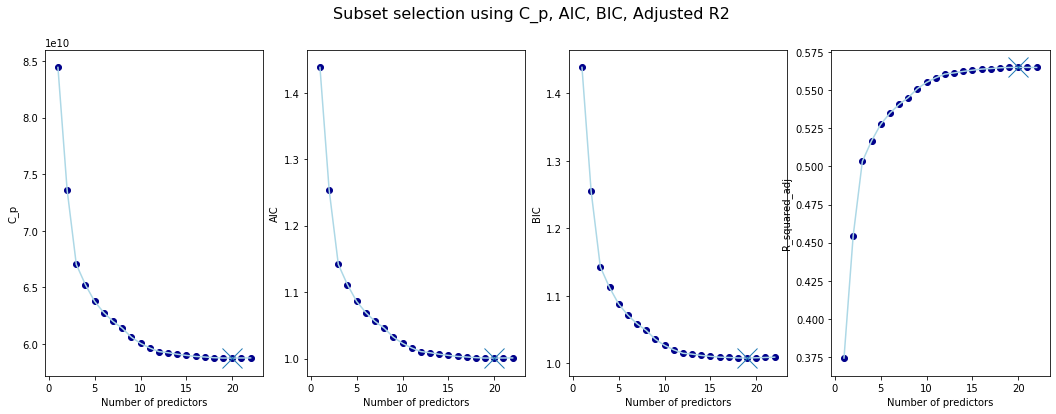

In [99]:
variables = ['C_p', 'AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
    ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()

In [57]:
#20 variables have the smallest Cp and AIC however that still seems like a lot of variables (mostly dummies)

In [100]:
df1['features'][20]

['scaled_sqft_living',
 'lat',
 'wtr_1.0',
 'view_4.0',
 'view_3.0',
 'view_2.0',
 'bedrooms',
 'long',
 'zipcode',
 'flr_2.5',
 'view_1.0',
 'cond_5',
 'flr_2.0',
 'cond_3',
 'yr_reno_2010',
 'flr_1.5',
 'flr_3.0',
 'sqft_lot',
 'flr_3.5',
 'bathrooms']

#### Create train and test sets

In [101]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state = 42)

In [102]:
linreg = LinearRegression()
linreg.fit(X_train, Y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [104]:
train_residuals = y_hat_train - Y_train
test_residuals = y_hat_test - Y_test

In [107]:
mse_train = np.sum((Y_train - y_hat_train)**2)/len(Y_train)
mse_test = np.sum((Y_test - y_hat_test)**2)/len(Y_test)
print('Train MSE: ', mse_train)
print('Test MSE: ', mse_test)

Train MSE:  59229611948.10296
Test MSE:  56407280083.16007


In [111]:
linreg.coef_

array([-4.01590204e+04,  4.17099681e+03,  2.11217382e+05,  1.13808870e+04,
       -6.84882505e+02,  7.76082566e+05, -3.06326834e+05,  4.26250004e+04,
        4.76383617e+04,  3.14889845e+05,  6.03472087e+04,  3.20982655e+05,
        1.71474926e+05,  1.47903016e+05,  2.57391013e+05,  4.56152347e+05,
        4.05881428e+04,  1.22667341e+04,  4.31918276e+04,  9.66519145e+04,
        5.63731809e+05,  1.26768715e+05])

In [112]:
linreg.intercept_

-6715767.981358671